# BENG0095 Project

## Introduction

In this notebook we will explore various binary classification algortihms, including Linear Discriminant Analysis (LDA), Quadratic Discriminant Analysis (QDA), Logistic Regression, and Naive Bayes. 

We will apply these algorithms to one toy data set, and two real-world datasets: the Pima Indians Diabetes data set; and the Wisconsin Diagnostic Breast Cancer data set. 

We will evaluate performances using three metrics: Classifcation Accuracy, the Receiver Operating Characteristic, and Precision/Recall scores.

## Imports

Please do not change the cell below, you will see a number of imports. All these packages are relevant for the assignment and it is important that you get used to them. You can find more information about them in their respective documentation. As usual Numpy, Pandas, and Scikit-Learn will be used heavily.

In [37]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt

from os import chdir
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# you may need to import sklearn.lda.LDA and sklearn.qda.QDA instead
# depending on which version you have installed
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB

from sklearn.metrics import accuracy_score, roc_curve, precision_recall_curve

## Toy Data Set

### Generate Toy Data Set:

We being by generating a toy dataset that contains two sets of Gaussian random variables:

In [2]:
np.random.seed(18)

n_sample, n_feature = 200, 2
cov = np.array([[0., -0.2], [0.8, .2]])
X = np.r_[np.dot(np.random.randn(n_sample, n_feature), cov),
          np.dot(np.random.randn(n_sample, n_feature), cov) + np.array([1, 1])]

y = np.hstack((np.zeros(n_sample), np.ones(n_sample)))

### Plot Decision Boundaries:

Next we define a function to plot data points and the decision boundary:

In [3]:
def plot_results(X, y, method, model, idx_plot):
    plt.subplot(1, 3, idx_plot)

    X0, X1 = X[y == 0], X[y == 1]  # data corresponding to classes 0 and 1

    plt.scatter(X0[:, 0], X0[:, 1], color='green')  # class 0
    plt.scatter(X1[:, 0], X1[:, 1], color='blue')  # class 1

    x_min, x_max = plt.xlim()
    y_min, y_max = plt.ylim()
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                         np.linspace(y_min, y_max, 100))
    Z = model.predict_proba(np.c_[xx.ravel(), yy.ravel()])
    Z = Z[:, 1].reshape(xx.shape)
    plt.contour(xx, yy, Z, [0.5], colors='black')
    
    plt.title(method)

### Make Predictions:
Finally we fit the data using Logistic Regression, LDA, and QDA models, and then visualise the results.

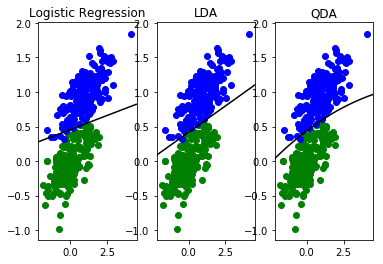

In [4]:
lr = LogisticRegression(solver = 'lbfgs')
lr.fit(X, y)
plot_results(X, y, 'Logistic Regression', lr, 1)

lda = LDA()
lda.fit(X, y)
plot_results(X, y, 'LDA', lda, 2)

qda = QDA()
qda.fit(X, y)
plot_results(X, y, 'QDA', qda, 3)

plt.show()

## International Match History Dataset

The International Match History Dataset compiles football match results of between national teams between 2004-09-03 and 2021-12-18.

The dataset contains data from 5,641 matches with 25 features:

1. Date
2. Home team (HT)
3. Away team (AT)
4. HT continent
5. AT continent
6. HT FIFA rank
7. AT FIFA rank
8. HT total FIFA points
9. AT total FIFA points
10. HT score
11. AT score
12. Tournament
13. City
14. Country
15. Neutral location
16. Shoot out
17. HT result
18. HT goalkeeper score
19. AT goalkeeper score
20. HT defense score
21. HT offense score
22. HT midfield score
23. AT defense score
24. AT offense score
25. AT midfield score

### Loading the dataset

We first load the dataset and visualise it to understand it better

In [38]:
# changing directory to current working directory
import os 
chdir(os.getcwd())

# reading raw .csv file
data = pd.read_csv('dataset/match_history.csv')

# date is imported as string, we change to datetime for easier cleaning
data['date'] = pd.to_datetime(data['date']).dt.date

In [39]:
# visualising first 5 rows
data.head()

,date,home_team,away_team,home_team_continent,away_team_continent,home_team_fifa_rank,away_team_fifa_rank,home_team_total_fifa_points,away_team_total_fifa_points,home_team_score,...,shoot_out,home_team_result,home_team_goalkeeper_score,away_team_goalkeeper_score,home_team_mean_defense_score,home_team_mean_offense_score,home_team_mean_midfield_score,away_team_mean_defense_score,away_team_mean_offense_score,away_team_mean_midfield_score
0,2004-09-03,Spain,Scotland,Europe,Europe,3,67,0,0,1,...,No,Draw,94.0,84.0,86.5,89.3,89.5,80.2,79.7,81.8
1,2004-09-04,Albania,Greece,Europe,Europe,94,14,0,0,2,...,No,Win,NaN,90.0,NaN,59.0,74.5,82.8,83.7,85.2
2,2004-09-04,Austria,England,Europe,Europe,90,7,0,0,2,...,No,Draw,83.0,88.0,76.2,73.0,74.0,90.5,88.7,91.2
3,2004-09-04,Croatia,Hungary,Europe,Europe,25,76,0,0,3,...,No,Win,77.0,74.0,80.5,78.7,79.0,71.8,75.7,70.2
4,2004-09-04,Denmark,Ukraine,Europe,Europe,15,87,0,0,1,...,No,Draw,82.0,NaN,79.5,85.0,81.5,NaN,81.7,65.8


### Plotting correlations

In order to understand better the numerical data before processing it, we want to see if any variables are particularly correlated.

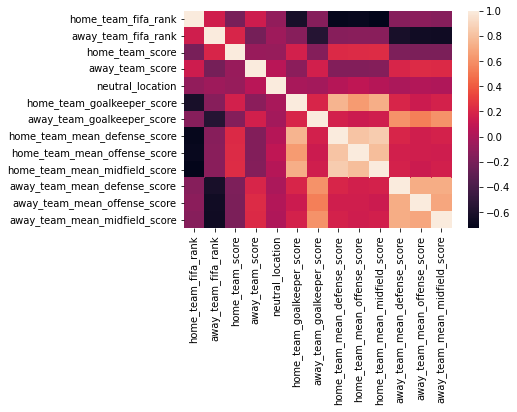

In [57]:
# compute correlations between features
corr = data.corr()

from seaborn import heatmap
heatmap(corr)

plt.show()

### _Takeaways_

1. Scores of different positions within the same team and same match are highly positively correlated.
2. Team FIFA rank and positions' scores are highly negatively correlated.

### Plotting features - Histogram

To understand data further, we plot histograms of all numerical features.

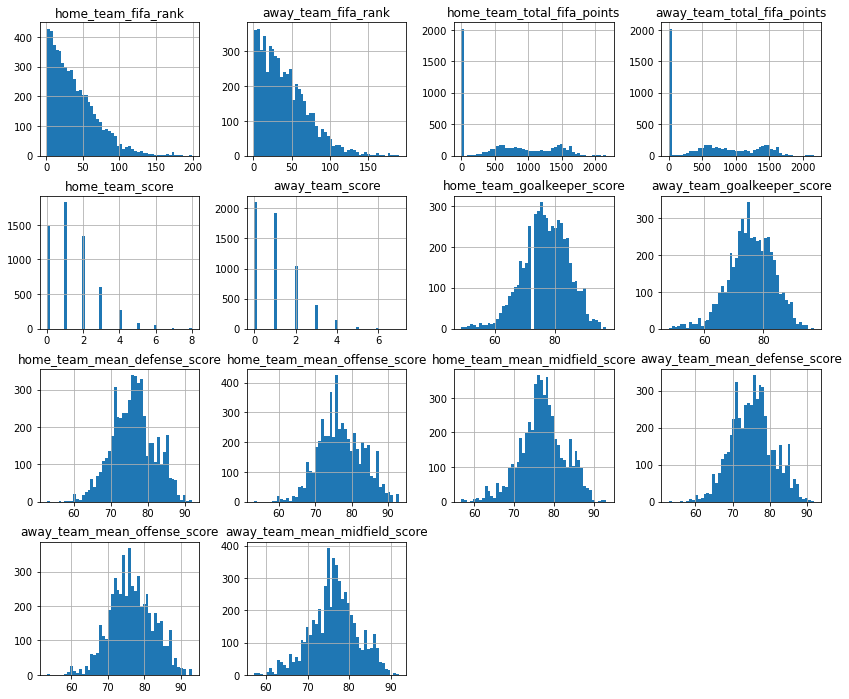

In [41]:
data.hist(bins=50, figsize=(14, 12))
plt.show()

### _Takeaways_

1. FIFA points columns (_home_team_total_fifa_points_ and _away_team_total_fifa_points_) have a large number of zeroes, which seems like a problem with the data and needs to be investigated further.
2. _home_team_goalkeeper_score_ seems to have a gap at around 72.
3. Most other data roughly follows normal distributions.

### Probing FIFA points

In order to clean the data, we first need to understand why there are large numbers of zero values in the FIFA points columns.

In [42]:
# select all rows where home team fifa points is zero
zero_points = data.query('home_team_total_fifa_points == 0')
zero_points.head()

,date,home_team,away_team,home_team_continent,away_team_continent,home_team_fifa_rank,away_team_fifa_rank,home_team_total_fifa_points,away_team_total_fifa_points,home_team_score,...,shoot_out,home_team_result,home_team_goalkeeper_score,away_team_goalkeeper_score,home_team_mean_defense_score,home_team_mean_offense_score,home_team_mean_midfield_score,away_team_mean_defense_score,away_team_mean_offense_score,away_team_mean_midfield_score
0,2004-09-03,Spain,Scotland,Europe,Europe,3,67,0,0,1,...,No,Draw,94.0,84.0,86.5,89.3,89.5,80.2,79.7,81.8
1,2004-09-04,Albania,Greece,Europe,Europe,94,14,0,0,2,...,No,Win,NaN,90.0,NaN,59.0,74.5,82.8,83.7,85.2
2,2004-09-04,Austria,England,Europe,Europe,90,7,0,0,2,...,No,Draw,83.0,88.0,76.2,73.0,74.0,90.5,88.7,91.2
3,2004-09-04,Croatia,Hungary,Europe,Europe,25,76,0,0,3,...,No,Win,77.0,74.0,80.5,78.7,79.0,71.8,75.7,70.2
4,2004-09-04,Denmark,Ukraine,Europe,Europe,15,87,0,0,1,...,No,Draw,82.0,NaN,79.5,85.0,81.5,NaN,81.7,65.8


In [43]:
# printing them in descending order by date
zero_points.sort_values(by = 'date', ascending=False).head()

,date,home_team,away_team,home_team_continent,away_team_continent,home_team_fifa_rank,away_team_fifa_rank,home_team_total_fifa_points,away_team_total_fifa_points,home_team_score,...,shoot_out,home_team_result,home_team_goalkeeper_score,away_team_goalkeeper_score,home_team_mean_defense_score,home_team_mean_offense_score,home_team_mean_midfield_score,away_team_mean_defense_score,away_team_mean_offense_score,away_team_mean_midfield_score
2016,2011-08-10,Wales,Australia,Europe,Oceania,112,22,0,0,1,...,No,Lose,75.0,80.0,74.2,71.0,80.2,72.5,76.7,71.0
2001,2011-08-10,Israel,Côte d'Ivoire,Europe,Africa,32,15,0,0,3,...,No,Lose,78.0,72.0,67.0,69.0,73.8,75.8,83.3,77.2
1989,2011-08-10,Austria,Slovakia,Europe,Europe,66,29,0,0,1,...,No,Lose,75.0,72.0,74.0,74.0,74.8,74.8,77.3,74.2
1990,2011-08-10,Belarus,Bulgaria,Europe,Europe,42,48,0,0,1,...,No,Win,75.0,77.0,63.0,71.0,72.2,71.2,75.3,75.0
1991,2011-08-10,Bosnia and Herzegovina,Greece,Europe,Europe,41,13,0,0,0,...,No,Draw,76.0,74.0,72.5,78.3,77.5,75.5,76.3,75.5


Interesting... All zero values seem to be between the dates of 2004-09-03 and 2011-08-10.

We need to make sure that all values between these dates are zero.

In [44]:
# printing all values not equal to zero and lower than the upper boundary (home team)
nonzero_points = data.query('home_team_total_fifa_points != 0')
nonzero_points[nonzero_points['date'] <= dt.date(2011, 8, 10)]

,date,home_team,away_team,home_team_continent,away_team_continent,home_team_fifa_rank,away_team_fifa_rank,home_team_total_fifa_points,away_team_total_fifa_points,home_team_score,...,shoot_out,home_team_result,home_team_goalkeeper_score,away_team_goalkeeper_score,home_team_mean_defense_score,home_team_mean_offense_score,home_team_mean_midfield_score,away_team_mean_defense_score,away_team_mean_offense_score,away_team_mean_midfield_score


In [45]:
# printing all values not equal to zero and lower than the upper boundary (away team)
nonzero_points = data.query('away_team_total_fifa_points != 0')
nonzero_points[nonzero_points['date'] <= dt.date(2011, 8, 10)]

,date,home_team,away_team,home_team_continent,away_team_continent,home_team_fifa_rank,away_team_fifa_rank,home_team_total_fifa_points,away_team_total_fifa_points,home_team_score,...,shoot_out,home_team_result,home_team_goalkeeper_score,away_team_goalkeeper_score,home_team_mean_defense_score,home_team_mean_offense_score,home_team_mean_midfield_score,away_team_mean_defense_score,away_team_mean_offense_score,away_team_mean_midfield_score


We found something! It seems like the dataset is missing values for the fifa points before 2011-08-10, this will need to be cleaned up

### Data Cleansing

Now that we understand the data better, it is time to clean it up before training the model.

### Position scores

From printing the first few values of the data, we also realised there were some null (or NaN) values at in the columns displaying the scores of the different positions (home team defense, away team goalkeeper, etc).

Nonetheless, as seen in the correlations diagram, there is a strong correlation between one position's score and the score of the other positions (within the same match). Therefore, we have chosen to fill in the NaN values with the average of the other positions within the team each match.

In [46]:
home_mean = data[['home_team_goalkeeper_score', \
                  'home_team_mean_defense_score', \
                  'home_team_mean_offense_score',\
                  'home_team_mean_midfield_score']].mean(axis=1)

home_mean.head()

0    89.825
1    66.750
2    76.550
3    78.800
4    82.000
dtype: float64

In [47]:
for i, col in enumerate(data):
    data.iloc[:, i] = data.iloc[:, i].fillna(home_mean)
    
data.head()

,date,home_team,away_team,home_team_continent,away_team_continent,home_team_fifa_rank,away_team_fifa_rank,home_team_total_fifa_points,away_team_total_fifa_points,home_team_score,...,shoot_out,home_team_result,home_team_goalkeeper_score,away_team_goalkeeper_score,home_team_mean_defense_score,home_team_mean_offense_score,home_team_mean_midfield_score,away_team_mean_defense_score,away_team_mean_offense_score,away_team_mean_midfield_score
0,2004-09-03,Spain,Scotland,Europe,Europe,3,67,0,0,1,...,No,Draw,94.00,84.0,86.50,89.3,89.5,80.2,79.7,81.8
1,2004-09-04,Albania,Greece,Europe,Europe,94,14,0,0,2,...,No,Win,66.75,90.0,66.75,59.0,74.5,82.8,83.7,85.2
2,2004-09-04,Austria,England,Europe,Europe,90,7,0,0,2,...,No,Draw,83.00,88.0,76.20,73.0,74.0,90.5,88.7,91.2
3,2004-09-04,Croatia,Hungary,Europe,Europe,25,76,0,0,3,...,No,Win,77.00,74.0,80.50,78.7,79.0,71.8,75.7,70.2
4,2004-09-04,Denmark,Ukraine,Europe,Europe,15,87,0,0,1,...,No,Draw,82.00,82.0,79.50,85.0,81.5,82.0,81.7,65.8


In [48]:
# checking if there are any remaining NaN values
data_nan = data[data.isna().any(axis=1)]
data_nan.head()

,date,home_team,away_team,home_team_continent,away_team_continent,home_team_fifa_rank,away_team_fifa_rank,home_team_total_fifa_points,away_team_total_fifa_points,home_team_score,...,shoot_out,home_team_result,home_team_goalkeeper_score,away_team_goalkeeper_score,home_team_mean_defense_score,home_team_mean_offense_score,home_team_mean_midfield_score,away_team_mean_defense_score,away_team_mean_offense_score,away_team_mean_midfield_score


Perfect! As we can see we have been able to replace all NaN values in the position scores section with the averages of the teams' scores.

### FIFA points cleanup

Given the values equal to zero in the FIFA points columns, we want to understand better how to get clean them.

In [49]:
# indentifying the data with FIFA points
mask = data['date'] > dt.date(2011, 8, 10)
data_post2011 = data.loc[mask]

data_post2011.head()

,date,home_team,away_team,home_team_continent,away_team_continent,home_team_fifa_rank,away_team_fifa_rank,home_team_total_fifa_points,away_team_total_fifa_points,home_team_score,...,shoot_out,home_team_result,home_team_goalkeeper_score,away_team_goalkeeper_score,home_team_mean_defense_score,home_team_mean_offense_score,home_team_mean_midfield_score,away_team_mean_defense_score,away_team_mean_offense_score,away_team_mean_midfield_score
2017,2011-08-27,Angola,Congo DR,Africa,Africa,96,127,338,221,1,...,No,Lose,70.0,67.066667,67.066667,69.7,61.5,69.2,69.7,70.0
2018,2011-09-02,Albania,France,Europe,Europe,57,15,546,918,1,...,No,Lose,70.0,86.000000,70.400000,69.7,71.5,82.5,83.0,84.5
2019,2011-09-02,Argentina,Venezuela,South America,South America,9,44,1016,615,1,...,No,Win,77.0,64.000000,80.800000,88.3,85.2,72.2,73.7,75.5
2020,2011-09-02,Belarus,Bosnia and Herzegovina,Europe,Europe,41,39,645,655,0,...,No,Lose,75.0,76.000000,63.200000,67.3,68.0,72.0,77.7,78.0
2021,2011-09-02,Bulgaria,England,Europe,Europe,51,4,585,1176,0,...,No,Lose,80.0,83.000000,70.800000,73.7,73.5,84.0,81.3,85.8


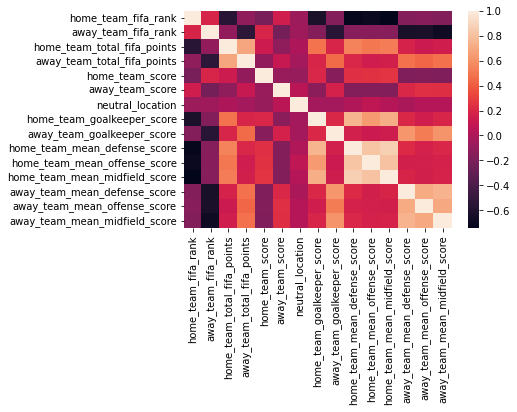

In [50]:
corr = data_post2011.corr()

heatmap(corr)

plt.show()

Interesting... it seems like there are some higher correlations between FIFA rank and FIFA points when data is nonzero.

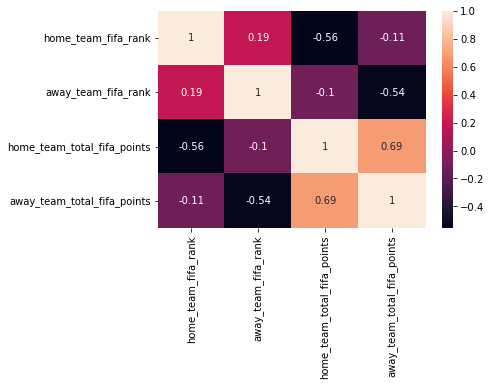

In [58]:
# compute correlations between features
corr = data_post2011[['home_team_fifa_rank', \
                      'away_team_fifa_rank', \
                      'home_team_total_fifa_points', \
                      'away_team_total_fifa_points']].corr()

heatmap(corr, annot=True)

plt.show()

Given the high correlation between FIFA rank and FIFA points, it seems like we can drop the FIFA points column with little impact on the performance of the model.

In [53]:
data = data.drop(columns=['home_team_total_fifa_points','away_team_total_fifa_points'])
data.head()

,date,home_team,away_team,home_team_continent,away_team_continent,home_team_fifa_rank,away_team_fifa_rank,home_team_score,away_team_score,tournament,...,shoot_out,home_team_result,home_team_goalkeeper_score,away_team_goalkeeper_score,home_team_mean_defense_score,home_team_mean_offense_score,home_team_mean_midfield_score,away_team_mean_defense_score,away_team_mean_offense_score,away_team_mean_midfield_score
0,2004-09-03,Spain,Scotland,Europe,Europe,3,67,1,1,Friendly,...,No,Draw,94.00,84.0,86.50,89.3,89.5,80.2,79.7,81.8
1,2004-09-04,Albania,Greece,Europe,Europe,94,14,2,1,FIFA World Cup qualification,...,No,Win,66.75,90.0,66.75,59.0,74.5,82.8,83.7,85.2
2,2004-09-04,Austria,England,Europe,Europe,90,7,2,2,FIFA World Cup qualification,...,No,Draw,83.00,88.0,76.20,73.0,74.0,90.5,88.7,91.2
3,2004-09-04,Croatia,Hungary,Europe,Europe,25,76,3,0,FIFA World Cup qualification,...,No,Win,77.00,74.0,80.50,78.7,79.0,71.8,75.7,70.2
4,2004-09-04,Denmark,Ukraine,Europe,Europe,15,87,1,1,FIFA World Cup qualification,...,No,Draw,82.00,82.0,79.50,85.0,81.5,82.0,81.7,65.8


### Split the Data Set

Before we start, we need to split the data set into a training set and a test set, as well as selecting the relevant columns.

In [54]:
# extract match result from dataset
X, y = data.drop('home_team_result', axis=1), data['home_team_result'].copy()

# drop final score given that this is also part of the match result
X = data.drop(columns=['home_team_score', 'away_team_score'], axis=1)

# split the dataset into training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=18)

In [55]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

TypeError: float() argument must be a string or a number, not 'datetime.date'

### Data Cleansing:

In Week 1, we used `sklearn.preprocessing.Imputer` to clean the data. 

Another option is to use `pandas.DataFrame.replace`, if the type of your dataset is `pandas.DataFrame`.

In this section, missing values of the following features are replaced with the mean value of the corresponding feature column. 

__Task:__  
Clean other features if necessary.

### _Plasma glucose concentration a 2 hours in an oral glucose tolerance test (PlGlcConc)_

In [12]:
mean_PlGlcConc = data['PlGlcConc'].mean()
data['PlGlcConc'] = data['PlGlcConc'].replace(to_replace=0, value=mean_PlGlcConc)

### _Diastolic blood pressure (BloodP)_

In [13]:
mean_BloodP = data['BloodP'].mean()
data['BloodP'] = data['BloodP'].replace(to_replace=0, value=mean_BloodP)

### _Triceps skin fold thickness (SkinThick)_

In [14]:
mean_SkinThick = data['SkinThick'].mean()
data['SkinThick'] = data['SkinThick'].replace(to_replace=0, value=mean_SkinThick)

### _Other Features_

In [15]:
##########################################################
# TO_DO

mean_BMI = data['BMI'].mean()
data['BMI'] = data['BMI'].replace(to_replace=0, value=mean_BMI)

# /TO_DO
##########################################################

### Split the Data Set:

Before we start, we need to split the data set into a training set and a test set:

In [16]:
# extract labels from the dataset
X, y = data.drop("DiabetesStatus", axis=1), data["DiabetesStatus"].copy()

# split the dataset into training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=18)

### Scale the Data Set:
Next we standardise the data set since the features are reported on different scales. 

Common scaling techniques include normalisation and binarisation. 

`sklearn.preprocessing` provides various feature scaling modules (use `help(preprocessing)` to check the documentation of these modules). 

In [17]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

/home/dariush/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/dariush/anaconda3/lib/python3.7/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/home/dariush/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  This is separate from the ipykernel package so we can avoid doing imports until


### Logistic Regression:

In [18]:
lr = LogisticRegression(solver = 'lbfgs')
lr.fit(X_train, y_train)
y_lr = lr.predict(X_test)
y_lr_prob = lr.predict_proba(X_test)[:, -1]  # probability estimates of the positive class
y_lr_score = lr.decision_function(X_test)  # confidence scores

### Naive Bayes:

In [19]:
nb = GaussianNB()
nb.fit(X_train, y_train)
y_nb = nb.predict(X_test)

### Linear Discriminant Analysis (LDA):

In [20]:
lda = LDA()
lda.fit(X_train, y_train)
y_lda = lda.predict(X_test)

### Quadratic Discriminant Analysis (QDA):

In [21]:
qda = QDA()
qda.fit(X_train, y_train)
y_qda = qda.predict(X_test)

### Compare Performances:
Finally we compare the performances with three different metrics: Classification Accuracy, ROC curve, and Precision-Recall score.

### _Classification Accuracy:_
Classification accuracy is perhaps the most popular and (apparently) natural metric for evaluating the performance of a classification algorithm. 

It can be conveniently computed by using `sklearn.metrics.accuracy_score`.

In [22]:
# create a dictionary variable with keys being algorithms names and values being classification predictions
results = dict(zip(['logistic regression', 'naive bayes', 'LDA', 
               'QDA'],
              [y_lr, y_nb, y_lda, y_qda]))

# create a dictionary variable with keys being algorithm names and values being classification accuracy
accuracy = {}
for algorithm, prediction in results.items():
    accuracy[algorithm] = accuracy_score(y_test, prediction)
    
accuracy = pd.DataFrame(data=accuracy, index=[0])
accuracy

,logistic regression,naive bayes,LDA,QDA
0,0.746753,0.707792,0.746753,0.675325


### _ROC Curve:_
A Receiver Operating Characteristic curve (ROC curve) is a graphical plot of the true positive rate (TPR) against the false positive rate (FPR), using different threshold settings:

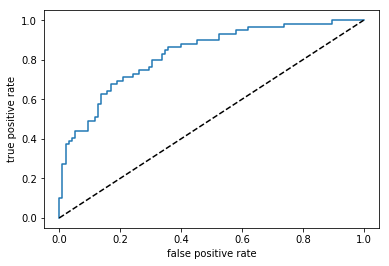

In [23]:
fpr, tpr, _ = roc_curve(y_test, y_lr_prob)  # false positive rates and true positive rates

# plot the ROC curve
fig, axis = plt.subplots()
axis.plot(fpr, tpr)
axis.plot([0, 1], [0, 1], 'k--')
axis.set_xlabel('false positive rate')
axis.set_ylabel('true positive rate')

plt.show()

### _Precision/Recall:_

The Precision/Recall, can be computed as follows:

$$
Precision = \frac{TP}{TP+FP}
$$
$$
Recall = \frac{TP}{TP + FN}
$$

Here *TP* is the number of true positives, *FP* is the number of false positives and *FN* is the number of false negatives. 

The terms 'positive' and 'negative' in the classification context refer to the prediction, and the terms 'true' and 'false' refer to whether the prediction corresponds to the observation.

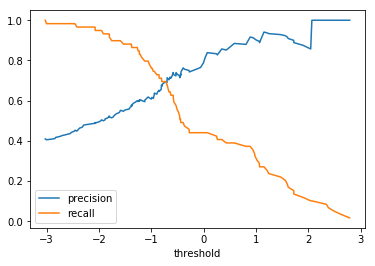

In [24]:
precision, recall, thresholds = precision_recall_curve(y_test, y_lr_score)  # precision, recall scores

fig, axis = plt.subplots()
axis.plot(thresholds, precision[:-1], label='precision')  # plot precision
axis.plot(thresholds, recall[:-1], label='recall')  # plot recall
axis.set_xlabel('threshold')
plt.legend()

plt.show()

## Wisconsin Diagnostic Breast Cancer Data Set

We have applied several binary classification algorithms to the Pima Indians Diabetes dataset. 

Now we will try a simialr exercise using the Wisconsin Diagnostic Breast Cancer data set (https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+(Diagnostic)).

The features from the Breast Cancer data set are computed from a digitized image of a fine needle aspirate (FNA) of a breast mass.  
The data set contains data from 569 females, whose diagosis of breast tissues are either malignant (212 samples) or benign (357 samples).  
The Breast Cancer data set has been pre-processed and cleaned with Scikit-Learn.

### Load Data Set:
The dataset can be loaded with `sklearn.datasets.load_breast_cancer`:

In [25]:
from sklearn.datasets import load_breast_cancer

breast_cancer = load_breast_cancer()
X = breast_cancer['data']
y = breast_cancer['target']

Descriptions of the columns of the data set can be viewed with the following code:

In [26]:
print(breast_cancer['DESCR'])

.. _breast_cancer_dataset:

Breast cancer wisconsin (diagnostic) dataset
--------------------------------------------

**Data Set Characteristics:**

    :Number of Instances: 569

    :Number of Attributes: 30 numeric, predictive attributes and the class

    :Attribute Information:
        - radius (mean of distances from center to points on the perimeter)
        - texture (standard deviation of gray-scale values)
        - perimeter
        - area
        - smoothness (local variation in radius lengths)
        - compactness (perimeter^2 / area - 1.0)
        - concavity (severity of concave portions of the contour)
        - concave points (number of concave portions of the contour)
        - symmetry 
        - fractal dimension ("coastline approximation" - 1)

        The mean, standard error, and "worst" or largest (mean of the three
        largest values) of these features were computed for each image,
        resulting in 30 features.  For instance, field 3 is Mean Radius, f

### Split the Data Set:
__Task:__  
Begin by splitting the data set into train and test parts:

In [27]:
##########################################################
# TO_DO

X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.2, random_state=18)

# /TO_DO
##########################################################

### Logistic regression:
__Task:__  
Next apply the Logistic Regression algorithm to train a model, then apply it to the test data and save the resulting predictions to a variable `y_lr`: 

In [35]:
##########################################################
# TO_DO

lr = LogisticRegression(solver='liblinear')
lr.fit(X_train, y_train)
y_lr = lr.predict(X_test)

# /TO_DO
##########################################################

### Naive Bayes:
__Task:__  
Next apply the Naive Bayes algorithm to train a model, then apply it to the test data and save the resulting predictions to a variable `y_nb`: 

In [29]:
##########################################################
# TO_DO

nb = GaussianNB()
nb.fit(X_train, y_train)
y_nb = nb.predict(X_test)

# /TO_DO
##########################################################

### LDA:
__Task:__  
Next apply the Naive Bayes algorithm to train a model, then apply it to the test data and save the resulting predictions to a variable `y_lda`: 

In [30]:
##########################################################
# TO_DO

lda = LDA()
lda.fit(X_train, y_train)
y_lda = lda.predict(X_test)

# /TO_DO
##########################################################

### QDA:
__Task:__  
Next apply the Naive Bayes algorithm to train a model, then apply it to the test data and save the resulting predictions to a variable `y_qda`: 

In [31]:
##########################################################
# TO_DO

qda = QDA()
qda.fit(X_train, y_train)
y_qda = qda.predict(X_test)

# /TO_DO
##########################################################

### Compare Performances:

__Task:__  
Finally, compare performances of your classification algorithms and visualise your results:

In [32]:
##########################################################
# TO_DO

# create a dictionary variable with keys being algorithms names and values being classification predictions
results = dict(zip(['logistic regression', 'naive bayes', 'LDA', 
               'QDA'],
              [y_lr, y_nb, y_lda, y_qda]))

# create a dictionary variable with keys being algorithm names and values being classification accuracy
accuracy = {}
for algorithm, prediction in results.items():
    accuracy[algorithm] = accuracy_score(y_test, prediction)
    
accuracy = pd.DataFrame(data=accuracy, index=[0])
accuracy

# /TO_DO
##########################################################

,logistic regression,naive bayes,LDA,QDA
0,0.947368,0.938596,0.964912,0.964912
